In [1]:
%matplotlib inline
import torch
from torch import nn
from torch.nn import functional as F
import dlc_practical_prologue as prologue
import matplotlib.pyplot as plt
from torch import optim

### Load Data ### 
N=1000
train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(N)

In [2]:
### Check tensors size
print(train_input.size(), train_target.size(), train_classes.size())

torch.Size([1000, 2, 14, 14]) torch.Size([1000]) torch.Size([1000, 2])


In [4]:
print(train_classes[1], train_target[1])

tensor([5, 4]) tensor(0)


In [5]:
def standardize(tensor):
    mu, std = tensor.mean(), tensor.std()
    return tensor.sub_(mu).div_(std)

In [6]:
train_input = standardize(train_input)
test_input = standardize(test_input)

In [7]:
train_input, train_target, train_classes = train_input.float().requires_grad_(), train_target.float().requires_grad_(), train_classes.float().requires_grad_()
test_input, test_target, test_classes = test_input.float().requires_grad_(), test_target.float().requires_grad_(), test_classes.float().requires_grad_()

In [8]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3) 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
    
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2,stride=2))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2,stride=2))
        return x

class shared_fclayer(nn.Module):
    def __init__(self):
        super(shared_fclayer,self).__init__()
        self.fc1 = nn.Linear(256,200)
        self.bn1 = nn.BatchNorm1d(200)
        self.fc2 = nn.Linear(200,100)  
        self.bn2 = nn.BatchNorm1d(100)
        self.fc3 = nn.Linear(100,10)
        self.dropout = nn.Dropout(0.25)
    
    def forward(self,x):
        x = self.dropout(self.bn1(F.relu(self.fc1(x.view(-1,256)))))
        x = self.dropout(self.bn2(F.relu(self.fc2(x))))
        x = F.relu(self.fc3(x))
        return x
    
class final_predictionlayer(nn.Module):
    def __init__(self):
        super(final_predictionlayer,self).__init__()
        self.final = nn.Linear(20,2)
    def forward(self,x):
        x = self.final(x)
        return x
    
class AuxLossWS_Net(nn.Module):
    def __init__(self):
        super(AuxLossWS_Net,self).__init__()
        self.ConvNet = ConvNet()
        self.fclayer = shared_fclayer()
        self.final = final_predictionlayer()
    def forward(self,x):
        tmp1 = x.narrow(1,0,1) #viewing only one image
        tmp2 = x.narrow(1,1,1) #viewing only one image
        #applying the conv layers
        tmp1 = self.ConvNet.forward(tmp1) 
        tmp2 = self.ConvNet.forward(tmp2)
        #applying the fc layers
        tmp1 = F.softmax(self.fclayer(tmp1),dim=1)
        tmp2 = F.softmax(self.fclayer(tmp2),dim=1)
        #viewing and final prediction
        output = torch.cat((tmp1,tmp2),1)
        output.view(-1,20)
        x = self.final(output)
        return x, tmp1, tmp2

In [9]:
def train_model(model, train_input, train_target, train_classes, mini_batch_size, nb_epochs, eta=9e-2, alpha=.75, gamma=1): 
    #Squeeze the classes labels (hotlabeling) for the auxLoss
    trainlabel_1 = (train_classes.narrow(1,0,1)).squeeze()
    trainlabel_2 = (train_classes.narrow(1,1,1)).squeeze()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(),lr=eta)
    losses = []
    
    for e in range(nb_epochs):
        sum_loss = 0
        for b in range(0, train_input.size(0), mini_batch_size):    
            
            out_compare, out_1, out_2 = model(train_input.narrow(0, b, mini_batch_size))
            #Main Loss
            loss_compare = criterion(out_compare, train_target.narrow(0, b, mini_batch_size).long())
            #AuxLoss
            loss_1 = criterion(out_1, trainlabel_1.narrow(0, b, mini_batch_size).long())
            loss_2 = criterion(out_2, trainlabel_2.narrow(0, b, mini_batch_size).long())
            #Weighted sum. Used to be Alpha*Loss1 + Beta*Loss2 + Gamma* Loss compare
            #Didn't work well, try again with other alpha/betas < 1.
            loss = alpha*loss_1 + alpha*loss_2 + gamma*loss_compare
            
            model.zero_grad()
            loss.backward()
            optimizer.step() 
            sum_loss += loss.item()
        
        losses.append(sum_loss)
        
    return losses

def compute_nb_errors(model, data_input, data_target, mini_batch_size):

    nb_errors = 0

    for b in range(0, data_input.size(0), mini_batch_size):
        output,_,_ = model(data_input.narrow(0, b, mini_batch_size))
        _, predicted_classes = torch.max(output, 1)
        for k in range(mini_batch_size):
            if data_target[b + k] != predicted_classes[k]:
                nb_errors += + 1

    return nb_errors

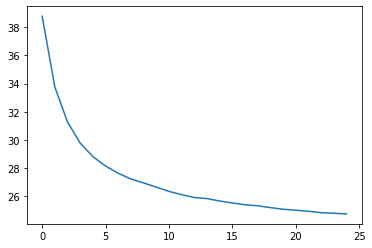

train error Net 1.50% 15/1000
test error Net 3.70% 37/1000


In [10]:
mini_batch_size = 100
model = AuxLossWS_Net()
l = train_model(model, train_input, train_target, train_classes, mini_batch_size, nb_epochs=25, eta=2e-1)
plt.figure()
plt.subplot(111)
plt.plot(range(len(l)),l)
plt.show()
model.train(False)
train_error = compute_nb_errors(model, train_input, train_target, mini_batch_size) 
test_error = compute_nb_errors(model, test_input, test_target, mini_batch_size)
print('train error Net {:0.2f}% {:d}/{:d}'.format((100 * train_error) / train_input.size(0), train_error, train_input.size(0)))
print('test error Net {:0.2f}% {:d}/{:d}'.format((100 * test_error) / test_input.size(0), test_error, test_input.size(0)))